In [72]:
import importlib

In [73]:
import test_model
importlib.reload(test_model);

In [107]:
import anc_complete
importlib.reload(anc_complete);

In [75]:
import lms_complete
importlib.reload(lms_complete);

In [197]:
import plot_helpers
importlib.reload(plot_helpers);

In [77]:
import boseqc20_model
importlib.reload(boseqc20_model);

In [78]:
import numpy as np

# Usando el Bose QC20

## Entrada con todas las frecuencias

In [79]:
N = 10000 # Quantity of samples used for the simulation  
x = np.random.normal(size=N) # Gaussian white noise

In [80]:
headphone = boseqc20_model.BoseQC20('../support/dataset/BoseQC20.json', secondary_enable=True, feedback_enable=True) # Create testbench model
headphone.set_noise(x) # Load the noise samples for the simulation
headphone.reset() # Reset the time instant

In [11]:
forget = 1
order = 1000
delta = np.var(headphone.xp) * (1 - forget)
e2, w2 = anc_complete.anc_complete(headphone, headphone.g, headphone.f, order=order, forget=forget, delta=10, force_hermitian=True, p_normalization=False)

Took 0.018153112959861648 seconds
Propagation: 1.225 %
Algorithm: 98.624 %
Update: 0.152 %


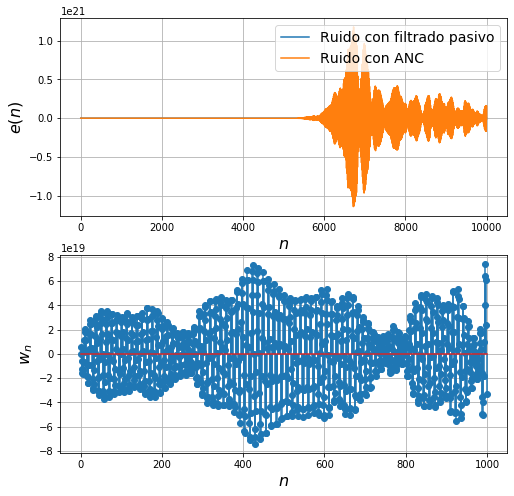

In [12]:
# Plot the ANC results
plot_helpers.plot_anc_results([headphone.d, e2], w2, weight_plot='response')

Observamos que para este caso, con $\lambda=1$, $\delta=10$, $M=1000$, el algoritmo FX-RLS convencional tiene problemas de estabilidad numerica.

## Entrada pasa altos

In [9]:
from scipy import signal

In [10]:
import matplotlib.pyplot as plt

In [16]:
# Coloured high-pass noise 
b, a = signal.butter(8, 10e3, btype='highpass', fs=48000)
x_hp = signal.lfilter(b, a, x)

In [17]:
headphone.set_noise(x_hp) # Load the noise samples for the simulation
headphone.reset() # Reset the time instant
forget = 1
order = 1000
delta = np.var(headphone.xp) * (1 - forget)
e_hp, w_hp = anc_complete.anc_complete(headphone, headphone.g, headphone.f, order=order, forget=forget, delta=10, force_hermitian=True, p_normalization=False)

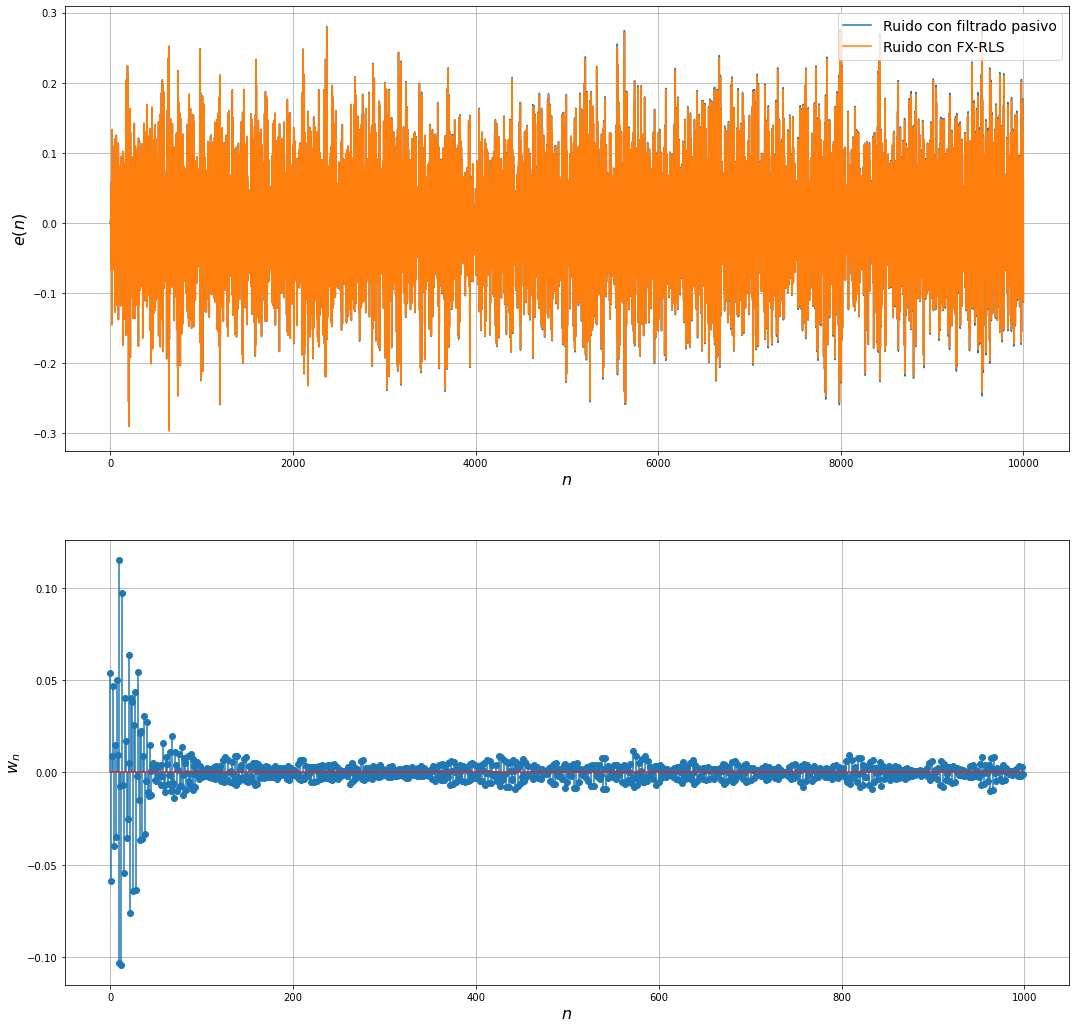

In [18]:
# Plot the ANC results
plot_helpers.plot_anc_results([headphone.d, e_hp], w_hp, weight_plot='response', labels=["Ruido con filtrado pasivo","Ruido con FX-RLS"])

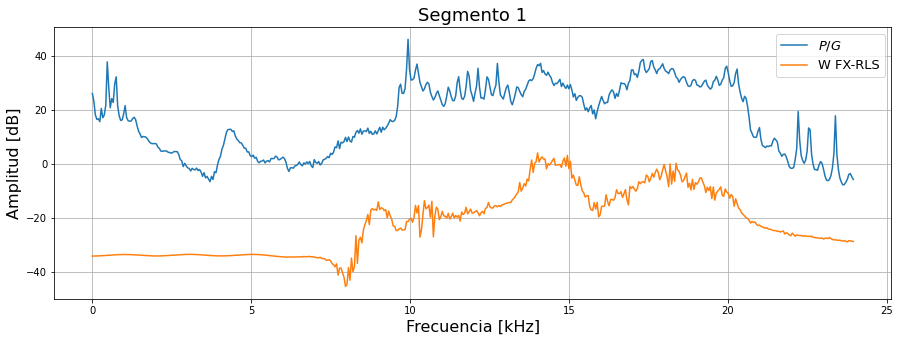

In [19]:
plot_helpers.plot_frequency_responses([headphone.p], [headphone.g], [[w_hp]], 48000, labels=['W FX-RLS'])

Observamos que para una entrada con solo altas frecuencias el algoritmo no diverge pero la performance es muy pobre dado que en altas frecuencias el SNR es aproximadamente 35dB peor que en bajas frecuencias

## Ruido pasa-banda

In [277]:
# Coloured band-pass noise 
b, a = signal.butter(8, [3e3, 4e3], btype='bandpass', fs=48000)
x_bp = signal.lfilter(b, a, x)

In [175]:
headphone = boseqc20_model.BoseQC20('../support/dataset/BoseQC20.json', secondary_enable=True, feedback_enable=True) # Create testbench model
headphone.set_noise(x_bp) # Load the noise samples for the simulation
headphone.reset() # Reset the time instant

In [176]:
forget = 1
order = 1000
delta = np.var(headphone.xp) * (1 - forget)
e_bp, w_bp = anc_complete.anc_complete(headphone, headphone.g, headphone.f, order=order, forget=forget, delta=10, force_hermitian=True, p_normalization=False)

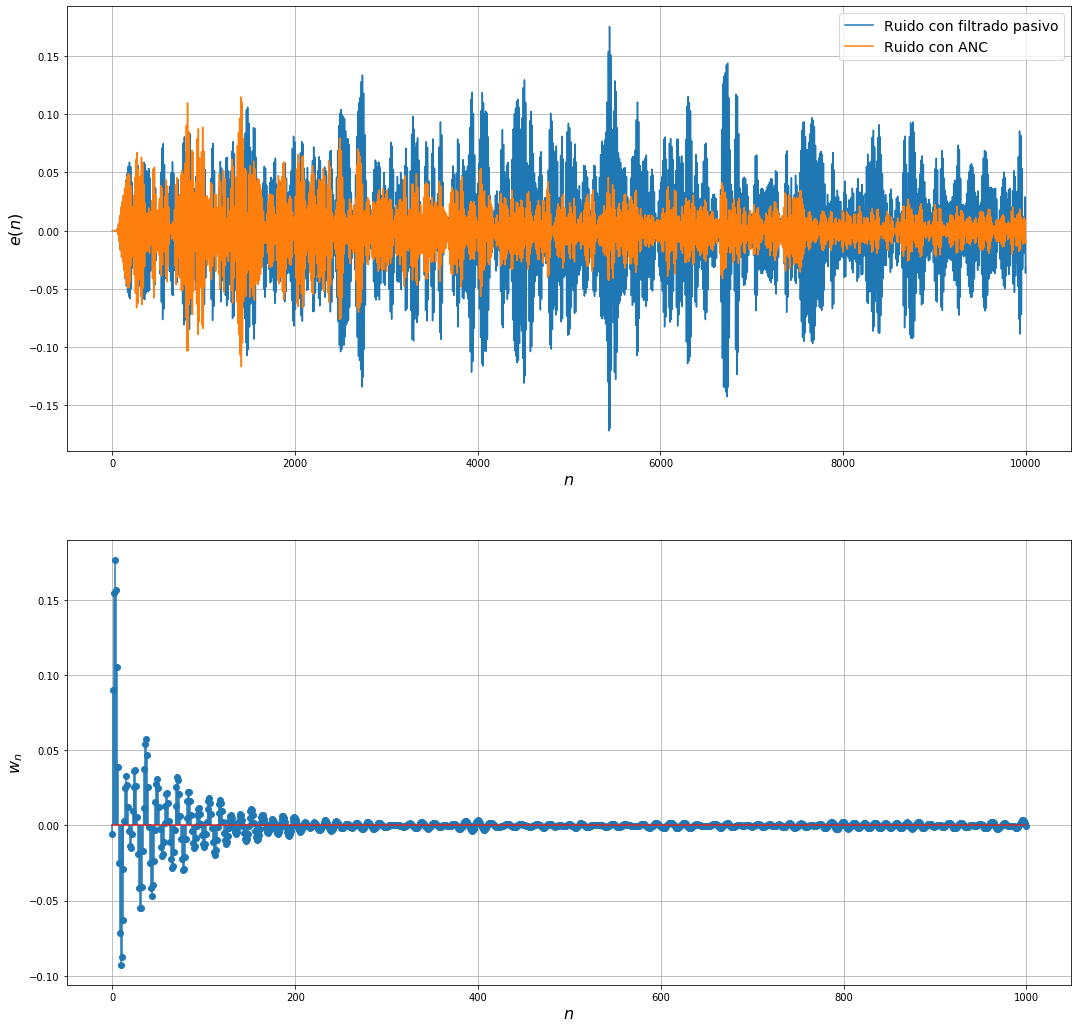

In [177]:
# Plot the ANC results
plot_helpers.plot_anc_results([headphone.d, e_bp], w_bp, weight_plot='response')

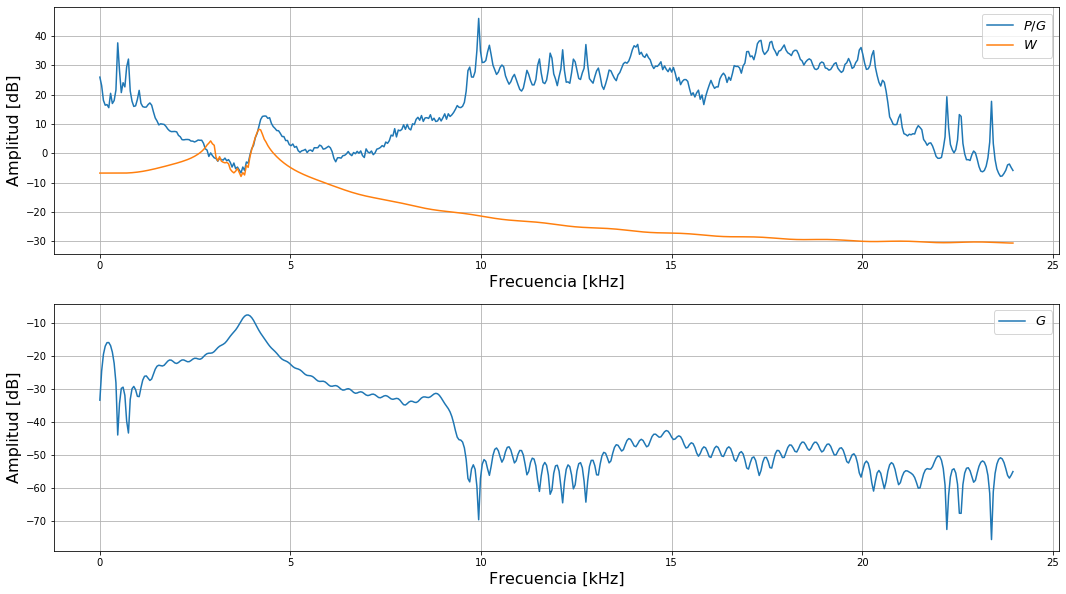

In [178]:
plot_helpers.plot_frequency_analysis(headphone.p, headphone.g, w_bp, 48000)

Por otro lado, para una entrada pasa banda en las frecuencias donde se tiene mejor SNR la performance es buena, el filtro adapta razonablemente las frecuencias que observa a la entrada.

## Analizando donde arranca la inestabilidad

In [139]:
N2 = 10000 # Quantity of samples used for the simulation  
x2 = np.random.normal(size=N2) # Gaussian white noise
headphone.set_noise(x2)

In [140]:
headphone.reset()
forget = 1
order = 1000
delta = np.var(headphone.xp) * (1 - forget)
e_broken, w_broken, w_history = anc_complete.anc_complete(headphone, headphone.g, headphone.f, order=order, forget=forget, delta=10, force_hermitian=True, p_normalization=False, weight_history=True)

Initial error = -0.08827824255002177
Initial g norm = 0.0004453031942768193
Took 0.020317883753776328 seconds
Propagation: 1.206 %
Algorithm: 98.463 %
Update: 0.331 %


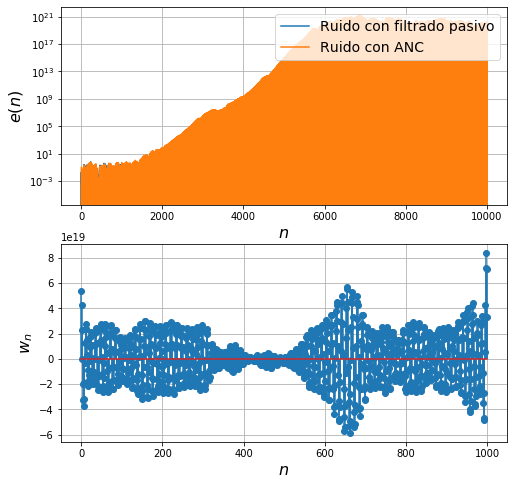

In [148]:
# Plot the ANC results
plot_helpers.plot_anc_results([headphone.d, e_broken], w_broken, weight_plot='response', log_scale=True)

Observamos el error en el tiempo con escala logaritmica para ver cuando comienza a diverger, vemos que es entre las muestras 1500 y 2000.

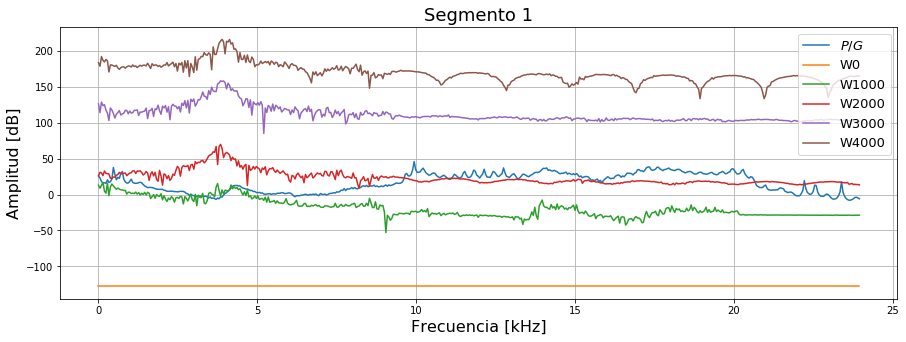

In [199]:
w_count = 5
w0 = 0
step = 1000
indexes = range(w0,w0+w_count*step,step)
aux_history = [[w_history[:,i]] for i in indexes]
plot_helpers.plot_frequency_responses([headphone.p], [headphone.g], aux_history, 48000, [f'W{i}' for i in indexes])

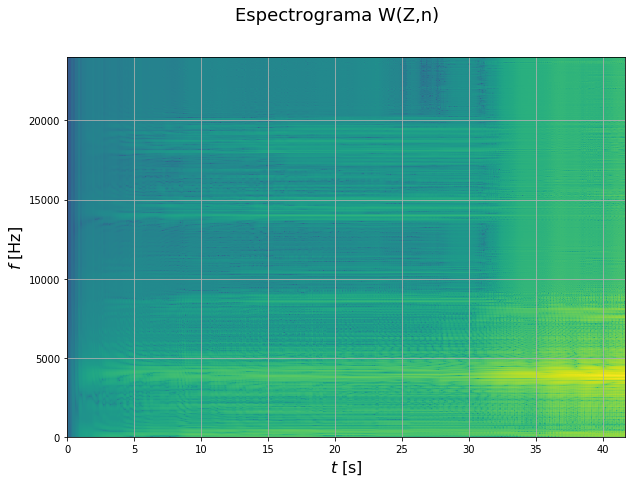

In [198]:
sample_count = 2000 # len(w_history[0]) 
aux_history = [w_history[:,i] for i in range(sample_count)]
aux = np.array(aux_history)
plot_helpers.plot_spectrogram(aux.flatten(), 48000, 'Espectrograma W(Z,n)', N=aux.shape[1])